# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: 25 October, 2025

**Student Name**: Antonia Horburger

**Professor**: Pablo Camarillo Ramirez

# Introduction

Los mercados financieros generan millones de datos cada segundo, incluyendo precios, órdenes y transacciones. Analizar toda esta información en tiempo real es esencial para detectar posibles fraudes o manipulaciones del mercado.
En este proyecto se construye un data pipeline en Apache Spark para procesar y transformar datos del libro de órdenes de Binance BTC/USDT, con el objetivo de identificar comportamientos anómalos mediante análisis por lotes.

# Dataset

**Modelo de datos**
Se usa un modelo relacional (tabular) porque el conjunto es estructurado y cada registro describe un nivel del libro de órdenes en un instante. Este formato facilita las transformaciones con Spark (agrupaciones por tiempo, joins, ventanas) y la persistencia posterior en SQL.

**Esquema (archivo CSV, una fila por nivel)**
- timestamp (long): marca temporal en milisegundos del snapshot
- price (double): precio del nivel
- quantity (double): cantidad disponible a ese precio
- side (string): lado del libro, “bid” (compra) o “ask” (venta)
- level (int): profundidad del nivel (1 = mejor precio)
- update_id (long): identificador de actualización de Binance

**Forma de obtener el dataset**
Se descarga desde un repositorio público de Kaggle:
https://www.kaggle.com/datasets/fast42/btc-l2-order-book-btcusdt-1s-11825

**Notas clave para el procesamiento**
El dataset está en formato “largo”, donde cada fila representa un nivel.
Para calcular métricas como el spread o el midprice, se agrupa por timestamp:
- best_bid = precio máximo con side = 'bid'
- best_ask = precio mínimo con side = 'ask'

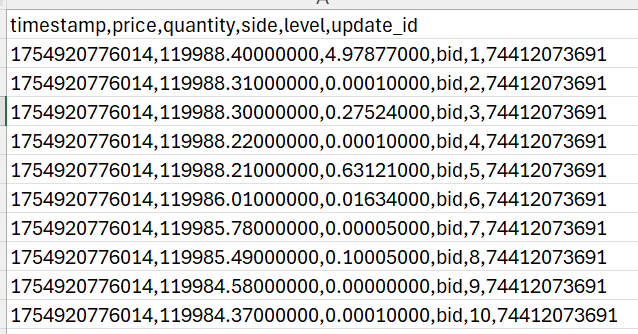

# Iniciar Spark Session

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Final Project")
    .master("spark://spark-master:7077")
    .config("spark.jars", "/opt/spark/work-dir/notebooks/jars/postgresql-42.3.3.jar")
    .config("spark.ui.port", "4040")
    .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/24 15:15:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

# Transformations and Actions

In [3]:
from antoniahorburger.spark_utils import SparkUtils
from pyspark.sql.functions import when, col, lit, avg, expr, count, to_timestamp, from_unixtime, date_trunc
from pyspark.sql import functions as F

base_path = "/opt/spark/work-dir/data/"

btc_schema_columns = [
    ("timestamp", "int"),
    ("price", "double"),
    ("quantity", "double"),
    ("side", "string"),
    ("level", "int"),
    ("update_id", "int")
]

btc_schema = SparkUtils.generate_schema(btc_schema_columns)

In [4]:
df = (
    spark.read
    .option("header", "true")
    .schema(btc_schema)
    .csv(base_path + "final_project/")
)

In [5]:
df = df.withColumn("ts", to_timestamp(from_unixtime(col("timestamp")/1000)))

df = df.withColumn("minute_ts", date_trunc("minute", col("ts")))


df = (
    df.filter(col("price") > 0)
      .filter(col("quantity") > 0)
      .filter(col("side").isin("bid", "ask"))
)

In [6]:
df = df.withColumn("ts", to_timestamp(from_unixtime(col("timestamp")/1000)))


df = df.withColumn("minute_ts", date_trunc("minute", col("ts")))


df = (
    df.filter(col("price") > 0)
      .filter(col("quantity") > 0)
      .filter(col("side").isin("bid", "ask"))
)

In [7]:
df_best = (
    df.groupBy("ts", "minute_ts")
      .agg(
          F.max(when(col("side") == "bid", col("price"))).alias("best_bid"),
          F.min(when(col("side") == "ask", col("price"))).alias("best_ask"),
          F.max(when(col("side") == "bid", col("quantity"))).alias("bid_qty"),
          F.max(when(col("side") == "ask", col("quantity"))).alias("ask_qty")
      )
)

In [8]:
df_features = (
    df_best
    .withColumn("midprice", (col("best_bid") + col("best_ask")) / 2)
    .withColumn("spread", col("best_ask") - col("best_bid"))
    .withColumn("spread_bps", (col("spread") / col("midprice")) * 10000)
    .withColumn(
        "imbalance",
        (col("bid_qty") - col("ask_qty")) / (col("bid_qty") + col("ask_qty"))
    )
)

In [9]:
df_minute = (
    df_features.groupBy("minute_ts")
    .agg(
        avg("midprice").alias("midprice_avg"),
        avg("spread_bps").alias("spread_bps_avg"),
        expr("percentile_approx(spread_bps, 0.95)").alias("spread_bps_p95"),
        avg("imbalance").alias("imbalance_avg"),
        count("*").alias("rows_per_minute")
    )
)

In [10]:
df_ready_per_ts = df_features.select("ts", "minute_ts", "midprice", "spread_bps", "imbalance")
df_ready_per_minute = df_minute

# Persistence Data

Se utiliza PostgreSQL porque el dataset tiene una estructura relacional: cada fila representa un registro con valores numéricos y categóricos bien definidos (timestamp, precio, cantidad, lado, etc.).
Este tipo de datos se adapta mejor a un modelo tabular donde se pueden realizar agregaciones, filtros y consultas SQL de forma eficiente.

In [11]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"

table_name_minute = "btc_features_minute"
df_ready_per_minute.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_minute) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

table_name_snapshot = "btc_features_snapshot"
df_ready_per_ts.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_snapshot) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

# DAG

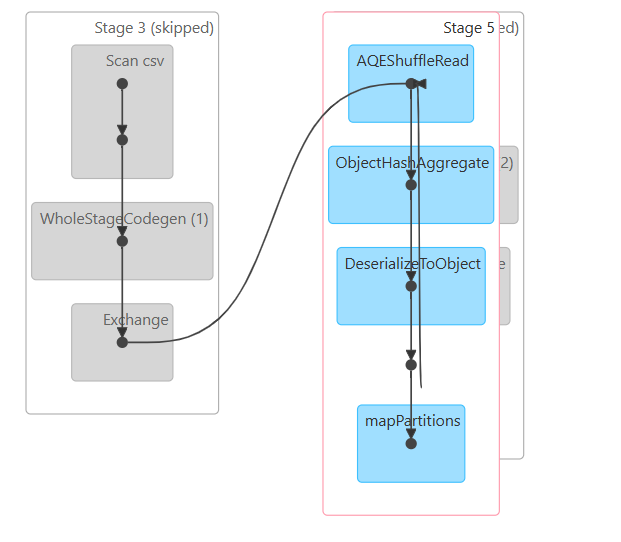